# Machine Learning Course Project (Fall 2023)

## Predicting HW grades from ChatGPT interactions

### Collaborators
- Selin Ceydeli
- Barış Tekdemir
- Mert Dursun
- Canberk Tahıl
- Onur Sezen

In [963]:
# Importing the necessary libraries
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [964]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:05<00:00, 24.87it/s]


In [965]:
# Let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework. Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distances to do the matching.

In [966]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [967]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [968]:
# Creating a dictionary out of the homework questions
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [969]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [970]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [971]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # Some html files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [972]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [973]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [974]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [975]:
questions[8]

'Find the information gain on the first split (10 pts)'

In [976]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts' average number of characters

In [977]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [978]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [979]:
# reading the scores
scores = pd.read_csv("./scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


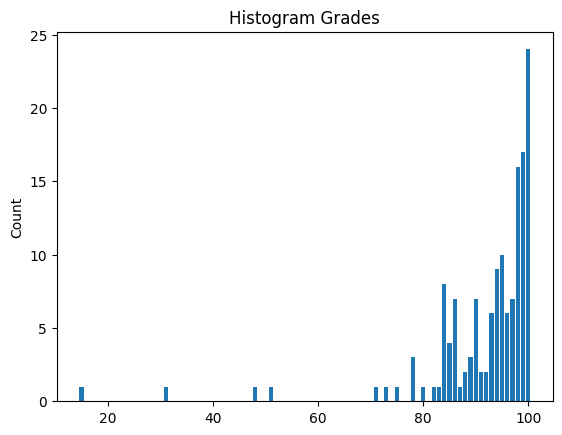

In [980]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [981]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [982]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [983]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


# Estimating Points Received Per Question by Clustering
- Apply a clustering algorithm to find clusters.
- Loop over the question columns and perform clustering on each one.
- After clustering, each student's response for a question is assigned a cluster label.
- The central value (mean) of each cluster (e.g. cluster center) is used to represent the typical score within that cluster for each question.

In [984]:
# Before making any modifications on the temp_df data frame, make a copy of it to later on apply Gaussian Mixture Model
temp_df2 = temp_df.copy()

### Clustering with K-Means Algorithm

In [985]:
# Define the maximum points for each question, adjust this if your data has fewer questions
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]

# Normalize the similarity scores to the range of points available for each question
for i in range(len(question_points)):
    # Ensure the column exists before trying to access it
    if f'Q_{i}' in temp_df.columns:
        temp_df[f'Q_{i}'] = temp_df[f'Q_{i}'] * question_points[i]

# Now, we'll use the normalized scores to cluster the data.
# We will use the KMeans algorithm to form clusters based on these scores.
# The number of clusters is set to the number of questions you have data for
num_clusters = 9

In [986]:
# Loop over the question columns and perform clustering on each one
for i in range(len([col for col in temp_df.columns if col.startswith('Q_')])):
    # Check if the question column exists
    if f'Q_{i}' in temp_df.columns:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(temp_df[[f'Q_{i}']])
        
        # Add the cluster labels to temp_df
        temp_df[f'Q_{i}_cluster'] = kmeans.labels_
        
        # Map each cluster label to the corresponding cluster center and add to temp_df
        cluster_centers = kmeans.cluster_centers_.squeeze()
        temp_df[f'Q_{i}_point_received'] = temp_df[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

# Outputting the first few rows of 'temp_df' to verify the clustering results
temp_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kme

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_4_cluster,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.0,...,7,4,7,11,8,2,3,3,5,2
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.0,...,2,5,8,19,1,13,8,11,1,5
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.0,...,6,6,2,9,2,7,8,11,0,3
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.0,...,4,3,6,6,8,2,0,5,8,4
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.0,...,8,7,0,18,3,9,6,19,4,4


In [987]:
# Print question and cluster information 
print(temp_df.iloc[:, 9:18].head())

   Q_0       Q_1        Q_2       Q_3       Q_4        Q_5        Q_6  \
0  0.0  1.474396   7.832540  1.761215  4.606063  11.077513   2.508756   
1  0.0  3.978035  11.582763  4.413282  6.071144  19.750224  13.388784   
2  0.0  1.479613   9.372367  1.759359  6.430377   9.086289   8.104040   
3  0.0  0.589206   4.010183  1.584045  3.338891   6.181681   2.886515   
4  0.0  2.877638  11.743251  3.124165  7.248722  17.443416  10.271962   

         Q_7       Q_8  
0   3.658762  1.954398  
1  11.414811  5.438659  
2  10.930117  3.257926  
3   5.237849  4.071058  
4  18.906107  5.117691  


In [988]:
print(temp_df.iloc[:, 19:27].head())

   Q_0_cluster  Q_0_point_received  Q_1_cluster  Q_1_point_received  \
0            0                   0            7                   1   
1            0                   0            8                   3   
2            0                   0            7                   1   
3            0                   0            5                   0   
4            0                   0            6                   2   

   Q_2_cluster  Q_2_point_received  Q_3_cluster  Q_3_point_received  
0            8                   7            0                   1  
1            6                  11            1                   4  
2            2                   9            0                   1  
3            0                   4            0                   1  
4            6                  11            2                   3  


In [989]:
print(temp_df.iloc[:, 27:37].head())

   Q_4_cluster  Q_4_point_received  Q_5_cluster  Q_5_point_received  \
0            7                   4            7                  11   
1            2                   5            8                  19   
2            6                   6            2                   9   
3            4                   3            6                   6   
4            8                   7            0                  18   

   Q_6_cluster  Q_6_point_received  Q_7_cluster  Q_7_point_received  \
0            8                   2            3                   3   
1            1                  13            8                  11   
2            2                   7            8                  11   
3            8                   2            0                   5   
4            3                   9            6                  19   

   Q_8_cluster  Q_8_point_received  
0            5                   2  
1            1                   5  
2            0                   3 

In [990]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in temp_df.columns if col.endswith('_point_received')]
temp_df['calculated_total_grade'] = temp_df[cluster_center_columns].sum(axis=1)

# Move the 'grade' column to the end
grade_column = temp_df['grade']
temp_df.drop(columns=['grade'], inplace=True)
temp_df['grade'] = grade_column

# Display the first few rows of the DataFrame to verify the new column
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.0,...,7,11,8,2,3,3,5,2,31,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.0,...,8,19,1,13,8,11,1,5,71,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.0,...,2,9,2,7,8,11,0,3,47,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.0,...,6,6,8,2,0,5,8,4,25,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.0,...,0,18,3,9,6,19,4,4,73,100.0


In [991]:
# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(temp_df['grade'], temp_df['calculated_total_grade'])
print("Mean Squared Error (MSE) for K-Means Algorithm:", mse)

Mean Squared Error (MSE) for K-Means Algorithm: 2179.9262295081967


In [992]:
# Adjusting the grades based on the difference from actual grades
for index, row in temp_df.iterrows():
    diff = row['grade'] - row['calculated_total_grade']
    change_amount = int(diff / num_clusters) # The division is casted to int to ensure that received points per questions are integers

    # Update the DataFrame with the adjusted values
    for key in row.index:
        if key.endswith('_point_received'):
            # Update the value in the DataFrame
            temp_df.at[index, key] += change_amount

# Now, re-calculate the cumulative grade column
# Sum the values in the cluster center columns for each row and store it in a new column
temp_df['calculated_total_grade'] = temp_df[cluster_center_columns].sum(axis=1)

In [993]:
# Drop the unnecessary columns from the temp_df DataFrame
columns_to_drop = [col for col in temp_df.columns if col.endswith('_cluster')]
temp_df.drop(columns=columns_to_drop, inplace=True)

# Display the first 15 rows of the modified DataFrame
temp_df.head(15)

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.0,...,2,8,2,5,12,3,4,3,40,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.0,...,6,14,7,8,22,16,14,8,98,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.0,...,5,13,5,10,13,11,15,7,83,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.0,...,8,12,9,11,14,10,13,12,97,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.0,...,5,14,6,10,21,12,22,7,100,100.0
5,090d6217-5d69-4929-a342-19abab78324f,73.0,13.0,0.0,0.0,0.0,19.0,0.006570,26.744905,0.0,...,4,10,4,7,19,12,14,9,80,84.0
7,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.0,0.0,0.0,0.0,3.0,0.380935,186.805893,0.0,...,5,10,6,10,19,14,18,7,92,96.0
8,0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,11.0,0.0,0.0,0.0,0.0,1.0,0.379206,75.604962,0.0,...,7,10,7,8,9,9,10,9,76,80.0
9,0e466794-f7f8-4cc2-b07e-070b13a0b5e1,46.0,6.0,0.0,0.0,0.0,3.0,0.006671,78.077540,0.0,...,3,13,2,8,20,14,18,8,87,89.0
10,0f0c953a-a472-47c1-809b-9fc14dba9091,17.0,3.0,0.0,0.0,1.0,0.0,0.302888,45.073739,0.0,...,3,8,4,9,22,16,8,3,76,83.0


### Clustering with Gaussian Mixture Model

In [994]:
temp_df2.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [995]:
# Normalize the similarity scores to the range of points available for each question
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]
for i in range(len(question_points)):
    if f'Q_{i}' in temp_df2.columns:
        temp_df2[f'Q_{i}'] = temp_df2[f'Q_{i}'] * question_points[i]

# Set the number of clusters (components) for Gaussian Mixture Model
num_clusters = 5

# Loop over the question columns and perform clustering using Gaussian Mixture Model
for i in range(len([col for col in temp_df2.columns if col.startswith('Q_')])):
    if f'Q_{i}' in temp_df2.columns:
        # Perform Gaussian Mixture Model clustering
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(temp_df2[[f'Q_{i}']])

        # Predict the cluster each sample belongs to
        temp_df2[f'Q_{i}_cluster'] = gmm.predict(temp_df2[[f'Q_{i}']])
        
        # Map each cluster label to the corresponding cluster center and add to temp_df2
        cluster_centers = gmm.means_.squeeze()
        temp_df2[f'Q_{i}_point_received'] = temp_df2[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [996]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in temp_df2.columns if col.endswith('_point_received')]
temp_df2['calculated_total_grade'] = temp_df2[cluster_center_columns].sum(axis=1)

In [997]:
# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(temp_df2['grade'], temp_df2['calculated_total_grade'])
print("Mean Squared Error (MSE) for Gaussian Mixture Model:", mse)

Mean Squared Error (MSE) for Gaussian Mixture Model: 2157.72131147541


In [998]:
# Adjusting the grades based on the difference from actual grades
for index, row in temp_df2.iterrows():
    diff = row['grade'] - row['calculated_total_grade']
    change_amount = diff / num_clusters
    for key in row.index:
        if key.endswith('_point_received'):
            temp_df2.at[index, key] += change_amount

# Re-calculate the cumulative grade column
temp_df2['calculated_total_grade'] = temp_df2[cluster_center_columns].sum(axis=1)

In [999]:
# Drop the unnecessary columns from the temp_df2 DataFrame
columns_to_drop = [col for col in temp_df2.columns if col.endswith('_cluster')]
temp_df2.drop(columns=columns_to_drop, inplace=True)

# Move the 'grade' column to the end
grade_column = temp_df2['grade']
temp_df2.drop(columns=['grade'], inplace=True)
temp_df2['grade'] = grade_column

# Display the first 15 rows of the modified DataFrame
temp_df2.head(15)

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.0,...,4.8,11.8,4.8,7.8,12.8,5.8,5.8,5.8,63.2,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.0,...,8.2,17.2,8.2,11.2,24.2,18.2,17.2,10.2,119.8,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.0,...,10.2,17.2,10.2,15.2,18.2,14.2,21.2,11.2,126.8,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.0,...,14.6,17.6,15.6,18.6,18.6,16.6,20.6,18.6,155.4,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.0,...,7.0,17.0,8.0,12.0,22.0,16.0,23.0,10.0,120.0,100.0
5,090d6217-5d69-4929-a342-19abab78324f,73.0,13.0,0.0,0.0,0.0,19.0,0.006570,26.744905,0.0,...,6.2,11.2,6.2,10.2,20.2,14.2,15.2,10.2,96.8,84.0
7,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.0,0.0,0.0,0.0,3.0,0.380935,186.805893,0.0,...,7.8,13.8,8.8,12.8,22.8,16.8,20.8,9.8,119.2,96.0
8,0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,11.0,0.0,0.0,0.0,0.0,1.0,0.379206,75.604962,0.0,...,13.6,16.6,13.6,14.6,15.6,15.6,15.6,15.6,134.4,80.0
9,0e466794-f7f8-4cc2-b07e-070b13a0b5e1,46.0,6.0,0.0,0.0,0.0,3.0,0.006671,78.077540,0.0,...,4.0,14.0,3.0,9.0,21.0,15.0,20.0,9.0,97.0,89.0
10,0f0c953a-a472-47c1-809b-9fc14dba9091,17.0,3.0,0.0,0.0,1.0,0.0,0.302888,45.073739,0.0,...,6.4,11.4,7.4,13.4,23.4,19.4,12.4,8.4,108.6,83.0


In [1000]:
# Using the temp_df data frame to find the X and y columns 
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 27) (122,)


# Data Splitting with Stratification

In [1001]:
# The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2 to apply stratification.
# Identify which classes in the target variable y are rare
y_series = pd.Series(y)
class_counts = y_series.value_counts()
threshold = 1
rare_classes = class_counts[class_counts <= threshold].index
print("There are", len(rare_classes), "rare classes.")
print("Rare classes:", rare_classes)

There are 11 rare classes.
Rare classes: Index([51.0, 82.0, 73.0, 48.0, 75.0, 31.0, 71.0, 87.0, 83.0, 80.0, 15.0], dtype='float64')


In [1002]:
# Creating a dictionary to map each rare class with its corresponding x values
rare_class_mapping = {}

# Iterate over the dataset to fill the mapping dictionary
for i, label in enumerate(y):
    if label in rare_classes:
        # Using tuple to represent X values since X is multi-dimensional
        rare_class_mapping[tuple(X[i])] = label

# Print the rare class mapping
print("Rare class mapping (showing first 5 entries):")
for i, (x_val, y_val) in enumerate(rare_class_mapping.items()):
    if i < 5:  # Limiting to first 5 entries for brevity
        print(f"X: {x_val}, Y: {y_val}")

Rare class mapping (showing first 5 entries):
X: (14.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.2057484646025123, 212.2063696746579, 0.0, 1.4743958595594324, 7.832539878900748, 1.7612153279521046, 4.606063455402357, 11.077513086858508, 2.5087564489007574, 3.6587617550470597, 1.9543980723403127, 1.0, 2.0, 8.0, 2.0, 5.0, 12.0, 3.0, 4.0, 3.0, 40.0), Y: 48.0
X: (11.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.37920580282402194, 75.60496195016243, 0.0, 0.4599965173829948, 3.165325131686357, 0.7004178983385629, 1.3801198122777156, 2.83797002585116, 2.493160096581104, 2.9176500321601493, 1.7782382740141842, 7.0, 7.0, 10.0, 7.0, 8.0, 9.0, 9.0, 10.0, 9.0, 76.0), Y: 80.0
X: (17.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.3028881801900086, 45.07373871576399, 0.0, 0.7729554733938314, 5.808897225558418, 1.5009699385813304, 6.787967224514034, 19.13453717525966, 13.067326257469764, 6.3203433531203, 1.273575986449008, 3.0, 3.0, 8.0, 4.0, 9.0, 22.0, 16.0, 8.0, 3.0, 76.0), Y: 83.0
X: (16.0, 2.0, 0.0, 0.0, 1.0, 3.0, 0.01821910780914412, 180.6976

In [1003]:
# Pair rare classes to apply stratification while splitting data

# Sort rare classes in increasing order of their frequency
sorted_rare_classes = rare_classes.sort_values(ascending=True)

# Pair them up and create a new label for each pair, ensuring no single-value group at the end
grouped_labels = {}
original_values = {}  # To store original values for each group
for i in range(0, len(sorted_rare_classes), 2):
    # If this is the last pair and there's an odd number of classes, include the last class in the previous group
    if i == len(sorted_rare_classes) - 1 and len(sorted_rare_classes) % 2 != 0:
        pair = sorted_rare_classes[i-1:i+1]
        new_label = f"group_{(i-1)//2}"
    else:
        pair = sorted_rare_classes[i:i+2]
        new_label = f"group_{i//2}"
    for cls in pair:
        grouped_labels[cls] = new_label
        original_values.setdefault(new_label, []).append(cls)

# Replace rare classes with their new grouped labels in the target variable
y_grouped = y_series.replace(grouped_labels)

# Print the first few rows of the new target variable
print(y_grouped.head())

# Print the mapping of groups to their original class values
print("Original values for each group:", original_values)

0    group_1
1       99.0
2       90.0
3       97.0
4      100.0
dtype: object
Original values for each group: {'group_0': [15.0, 31.0], 'group_1': [48.0, 51.0], 'group_2': [71.0, 73.0], 'group_3': [75.0, 80.0], 'group_4': [82.0, 83.0, 83.0, 87.0]}


In [1004]:
# Update the rare_class_mapping to include both original y value and new group label
for x_val in rare_class_mapping.keys():
    original_y_val = rare_class_mapping[x_val]
    if original_y_val in grouped_labels:
        group_label = grouped_labels[original_y_val]
        # Store both the original y value and the new group label
        rare_class_mapping[x_val] = {'original_y': original_y_val, 'group_label': group_label}

# Print the updated rare class mapping (showing first 5 entries for brevity)
print("Updated rare class mapping with both values and labels (showing first 5 entries):")
for i, (x_val, mapping_info) in enumerate(rare_class_mapping.items()):
    if i < 5:
        print(f"X: {x_val}, Original Y: {mapping_info['original_y']}, Group Label: {mapping_info['group_label']}")

Updated rare class mapping with both values and labels (showing first 5 entries):
X: (14.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.2057484646025123, 212.2063696746579, 0.0, 1.4743958595594324, 7.832539878900748, 1.7612153279521046, 4.606063455402357, 11.077513086858508, 2.5087564489007574, 3.6587617550470597, 1.9543980723403127, 1.0, 2.0, 8.0, 2.0, 5.0, 12.0, 3.0, 4.0, 3.0, 40.0), Original Y: 48.0, Group Label: group_1
X: (11.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.37920580282402194, 75.60496195016243, 0.0, 0.4599965173829948, 3.165325131686357, 0.7004178983385629, 1.3801198122777156, 2.83797002585116, 2.493160096581104, 2.9176500321601493, 1.7782382740141842, 7.0, 7.0, 10.0, 7.0, 8.0, 9.0, 9.0, 10.0, 9.0, 76.0), Original Y: 80.0, Group Label: group_3
X: (17.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.3028881801900086, 45.07373871576399, 0.0, 0.7729554733938314, 5.808897225558418, 1.5009699385813304, 6.787967224514034, 19.13453717525966, 13.067326257469764, 6.3203433531203, 1.273575986449008, 3.0, 3.0, 8.0, 4.0, 9.0, 22.

In [1005]:
# Check if there are any more rare classes after grouping
y_series = pd.Series(y_grouped)
class_counts = y_series.value_counts()
threshold = 1
rare_classes = class_counts[class_counts <= threshold].index
print("There are", len(rare_classes), "rare classes.")

There are 0 rare classes.


In [1006]:
# Now, perform data splitting
# Convert y_grouped from a pandas Series to a numpy array and ensure all elements are strings
y_grouped_array = y_grouped.astype(str).to_numpy()

# Since the data is imbalanced with respect to student grades, apply train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y_grouped_array, test_size=0.2, random_state=42, stratify=y_grouped_array)

# Print the sizes of the train and test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

print("Sample of y_train:", y_train[:20])
print("Sample of y_test:", y_test[:20])

Train set size: 97
Test set size: 25
Sample of y_train: ['93.0' '94.0' '99.0' '95.0' 'group_2' '78.0' '100.0' '78.0' '100.0'
 '100.0' '99.0' '85.0' '97.0' '97.0' '84.0' '88.0' 'group_1' '98.0' '98.0'
 '98.0']
Sample of y_test: ['95.0' '90.0' '100.0' '94.0' '99.0' '89.0' '94.0' '97.0' '99.0' '84.0'
 '99.0' '98.0' '95.0' '90.0' '100.0' '86.0' '97.0' '100.0' 'group_4'
 '100.0']


In [1007]:
# Replace the group labels in y_train and y_test with their original values

# Convert y_train and y_test back to pandas Series for easier manipulation
# Use the range of the length of y_train and y_test as index
y_train_series = pd.Series(y_train, index=range(len(y_train)))
y_test_series = pd.Series(y_test, index=range(len(y_test)))

# Iterate over the rare_class_mapping to replace group labels with original y values
for x_val, mapping_info in rare_class_mapping.items():
    original_y = mapping_info['original_y']
    group_label = mapping_info['group_label']

    # Check if the x_val matches in either X_train or X_test
    # Compare using the indices from y_train_series and y_test_series
    matching_train_indices = [index for index, row in enumerate(X_train) if np.array_equal(row, x_val)]
    matching_test_indices = [index for index, row in enumerate(X_test) if np.array_equal(row, x_val)]

    # Replace group label with original y value where the x_values match
    for index in matching_train_indices:
        if y_train_series.at[index] == group_label:
            y_train_series.at[index] = original_y
    for index in matching_test_indices:
        if y_test_series.at[index] == group_label:
            y_test_series.at[index] = original_y

# Convert the Series back to numpy arrays
y_train = y_train_series.to_numpy()
y_test = y_test_series.to_numpy()

# Print the sizes of the train and test sets and a few samples
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Sample of y_train:", y_train[:20])
print("Sample of y_test:", y_test[:20])

Train set size: 97
Test set size: 25
Sample of y_train: ['93.0' '94.0' '99.0' '95.0' 73.0 '78.0' '100.0' '78.0' '100.0' '100.0'
 '99.0' '85.0' '97.0' '97.0' '84.0' '88.0' 48.0 '98.0' '98.0' '98.0']
Sample of y_test: ['95.0' '90.0' '100.0' '94.0' '99.0' '89.0' '94.0' '97.0' '99.0' '84.0'
 '99.0' '98.0' '95.0' '90.0' '100.0' '86.0' '97.0' '100.0' 83.0 '100.0']


# Fitting a model

#### Predicting and Analyzing 

In [1008]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [1009]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 182.5322563503014
Node 1 has MSE 208.6875
Node 2 has MSE 64.0
Node 3 has MSE 0.0
Node 4 has MSE 0.0
Node 5 has MSE 2.25
Node 6 has MSE 0.0
Node 7 has MSE 0.0
Node 8 has MSE 46.63059313215308
Node 9 has MSE 32.78240190249835
Node 10 has MSE 9.805555555556566
Node 11 has MSE 0.8888888888877773
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 2.66666666666697
Node 15 has MSE 0.0
Node 16 has MSE 1.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 10.510396975425465
Node 20 has MSE 6.40816326530512
Node 21 has MSE 1.8888888888895963
Node 22 has MSE 0.9600000000000364
Node 23 has MSE 0.8888888888895963
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 0.0
Node 28 has MSE 4.6488888888898146
Node 29 has MSE 1.0399999999990541
Node 30 has MSE 0.0
Node 31 has MSE 0.5
Node 32 has MSE 0.22222222222262644
Node 33 has MSE 0.0
Node 34 has MSE 0.0
Node 35 has MSE 0.0
Node 36 has MSE 1.890000000001237
Node 37 has MSE 0.33333333333303017
Node 38 ha

In [1010]:
"""
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")
"""

'\n# Plotting the Tree \ndot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])\ngraph = graphviz.Source(dot_data)\ngraph.render("hw")\n'

In [1011]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 0.0
MSE TEST: 16.0
R2 Train: 1.0
R2 TEST: 0.45217486578284205
